In [1]:
import pandas as pd
import re
import unicodedata
import seaborn as sns
import spacy
import matplotlib.pyplot as plt
from nltk.probability import FreqDist # This is for counting the most frequent words
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize # this is for counting the senteces
plt.style.use('ggplot')

from collections import Counter
from functools import reduce
import language_tool_python

import warnings
warnings.filterwarnings('ignore')

# EDA of "GPT vs. Human: A Corpus of Research Abstracts"

In [2]:
data = pd.read_csv("data_set.csv" , index_col= False )
data.head(5)

,title,abstract,ai_generated,is_ai_generated
0,Are Advanced Potentials Anomalous?,Advanced electromagnetic potentials are indi...,False,0
1,Are Advanced Potentials Anomalous?,This research paper investigates the question ...,True,1
2,An efficient centralized binary multicast netw...,We give an algorithm for finding network enc...,False,0
3,An efficient centralized binary multicast netw...,The paper presents an efficient centralized bi...,True,1
4,Percolation transition in networks with degree...,We introduce an exponential random graph mod...,False,0


In [3]:
print(data.shape)
data.info()
# This dataset is bigger than the other one

(4053, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4053 entries, 0 to 4052
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            4053 non-null   object
 1   abstract         4053 non-null   object
 2   ai_generated     4053 non-null   bool  
 3   is_ai_generated  4053 non-null   int64 
dtypes: bool(1), int64(1), object(2)
memory usage: 99.1+ KB


In [4]:
# Checking missing values...
data.isna().sum()
# No Missing values as before

title              0
abstract           0
ai_generated       0
is_ai_generated    0
dtype: int64

/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


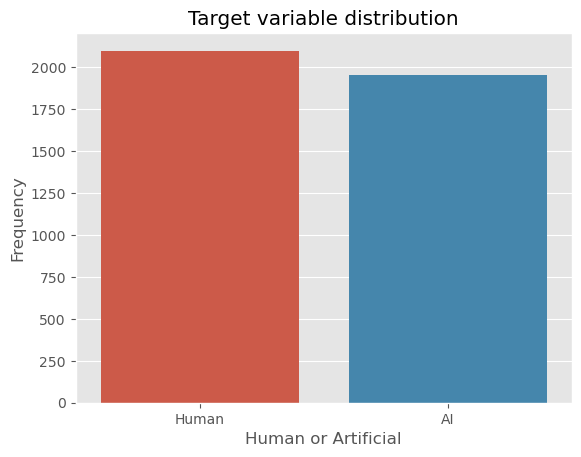

In [5]:
# What about the target class distro? It should be totally balanced because for every question we have 2 answers
fig = sns.countplot(data, x = 'ai_generated')
fig.set(title = 'Target variable distribution', xlabel = 'Human or Artificial', ylabel = 'Frequency', xticklabels=['Human','AI'] )
plt.show()
# There are a bit less AI responses

## EDA --> Counts and lengths

### Character Count

In [6]:
def article_length(text):
    return len(text)
data['length'] = data['abstract'].apply(article_length) 
print(data[data['is_ai_generated']==0].length.mean())
print(data[data['is_ai_generated']==1].length.mean())

911.6428571428571
790.5340501792115


/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

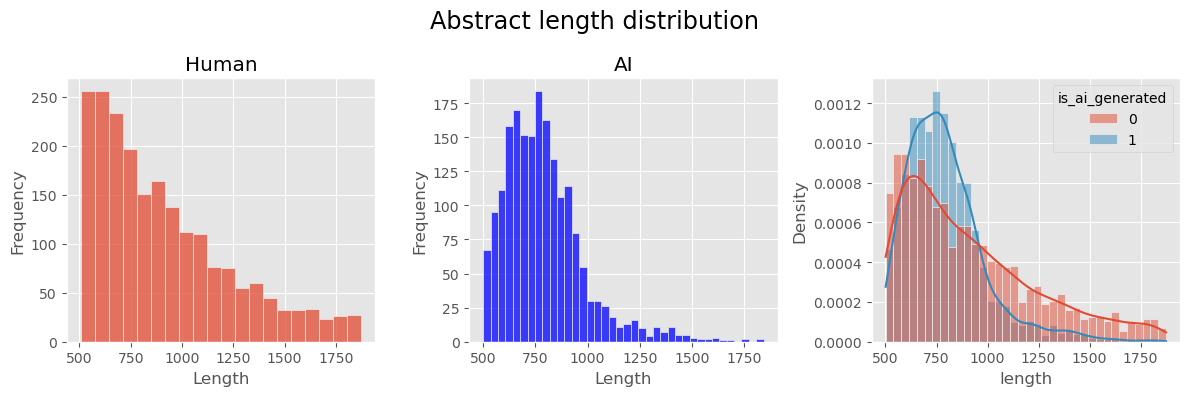

In [7]:
fig, axes = plt.subplots(1,3, figsize = (12,4))
fig_dist_human = sns.histplot(data = data[data['is_ai_generated']==0], x = 'length', ax = axes[0])
fig_dist_human.set(title = 'Human', xlabel='Length', ylabel= 'Frequency')
fig_dist_ai = sns.histplot(data = data[data['is_ai_generated']==1], x = 'length', ax = axes[1], color = 'blue')
fig_dist_ai.set(title = 'AI', xlabel='Length', ylabel= 'Frequency')
fig.suptitle('Abstract length distribution', fontsize =  'xx-large')
sns.histplot(data = data, x = 'length', hue='is_ai_generated', kde= True, stat = 'density', ax = axes[2] ) # Overlapped
plt.tight_layout()

### Words Count

/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

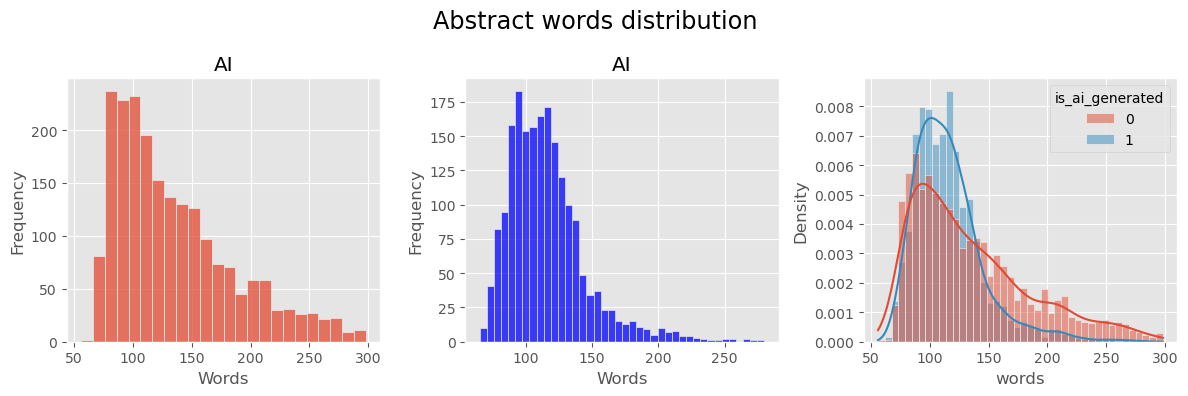

In [8]:
data['words'] = data['abstract'].apply(lambda x: len(str(x).split()))
figg, axes = plt.subplots(1,3, figsize = (12,4))
fig_dist_human = sns.histplot(data = data[data['is_ai_generated']==0], x = 'words', ax = axes[0])
fig_dist_human.set(title = 'AI', xlabel='Words', ylabel= 'Frequency')
fig_dist_ai = sns.histplot(data = data[data['is_ai_generated']==1], x = 'words', ax = axes[1], color='blue')
fig_dist_ai.set(title = 'AI', xlabel='Words', ylabel= 'Frequency')
sns.histplot(data = data, x = 'words', hue='is_ai_generated', kde= True, stat = 'density', ax = axes[2]) 
figg.suptitle('Abstract words distribution', fontsize =  'xx-large')
plt.tight_layout()

### Sentences Count

/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

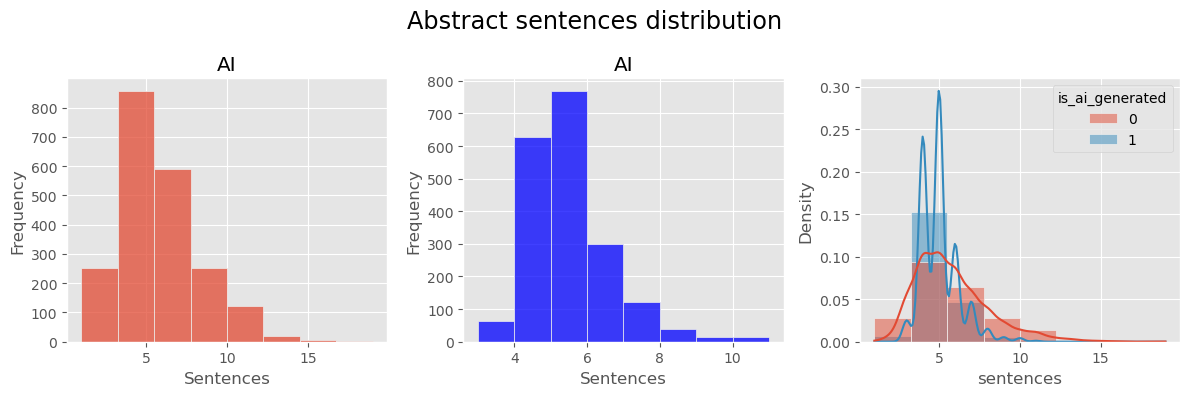

In [9]:
data['sentences'] = data['abstract'].map(lambda x: len(sent_tokenize(x)))
fig, axes = plt.subplots(1,3, figsize = (12,4))
fig_sentences_human = sns.histplot(data = data[data['is_ai_generated']==0], x = 'sentences', ax = axes[0], bins = 8)
fig_sentences_human.set(title = 'AI', xlabel='Sentences', ylabel= 'Frequency')
fig_sentences_ai = sns.histplot(data = data[data['is_ai_generated']==1], x = 'sentences', ax = axes[1], color='blue',bins = 8)
fig_sentences_ai.set(title = 'AI', xlabel='Sentences', ylabel= 'Frequency')
sns.histplot(data = data, x = 'sentences', hue='is_ai_generated', kde= True, stat = 'density', ax = axes[2], bins = 8) 
fig.suptitle('Abstract sentences distribution', fontsize =  'xx-large')
plt.tight_layout()

# EDA --> Term frequency analysis

Steps we will follow:
1) Convert to lowercase
2) remove urls and html tags if any
3) Remove strange acceted characters if any
4) Remove punctuation
5) Remove extra white spaces 
6) Delet stop words

In [10]:
# Our functions
def lowering(text):
    return text.lower()

def remove_url(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def remove_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

def remove_punctuation(text):
    return re.sub(r'[^a-zA-Z0-9]', ' ', text)

def remove_extra_spaces(text):
    return re.sub(r'^\s*|\s\s*', ' ', text).strip()

en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
def delete_stopwords(text):
    words = [word for word in text.split() if word.lower() not in sw_spacy]
    new_text = " ".join(words)
    return new_text

In [11]:
len(data[data.abstract.str.contains('http')]) #only 4

4

In [30]:
data['abstract_clean'] = data.abstract.apply(lowering)   
data['abstract_clean'] = data.abstract_clean.apply(remove_url)
data['abstract_clean'] = data.abstract_clean.apply(remove_accents)
data['abstract_clean'] = data.abstract_clean.apply(remove_punctuation)
data['abstract_clean'] = data.abstract_clean.apply(remove_extra_spaces)
data['abstract_nopunct'] = data.abstract_clean.copy()
data['abstract_clean'] = data.abstract_clean.apply(delete_stopwords)

#### Most common words

In [13]:
def most_common_words(data):
    corpus = [word for i in data['abstract_clean'].str.split().values.tolist() for word in i]
    most_common = FreqDist(corpus).most_common(40)
    words, frequency = [], []
    for word, count in most_common:
        words.append(word)
        frequency.append(count)   
    return dict(zip(words, frequency))
most_1_human = most_common_words(data[data['is_ai_generated']==0])
most_1_ai = most_common_words(data[data['is_ai_generated']==1])

/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use is

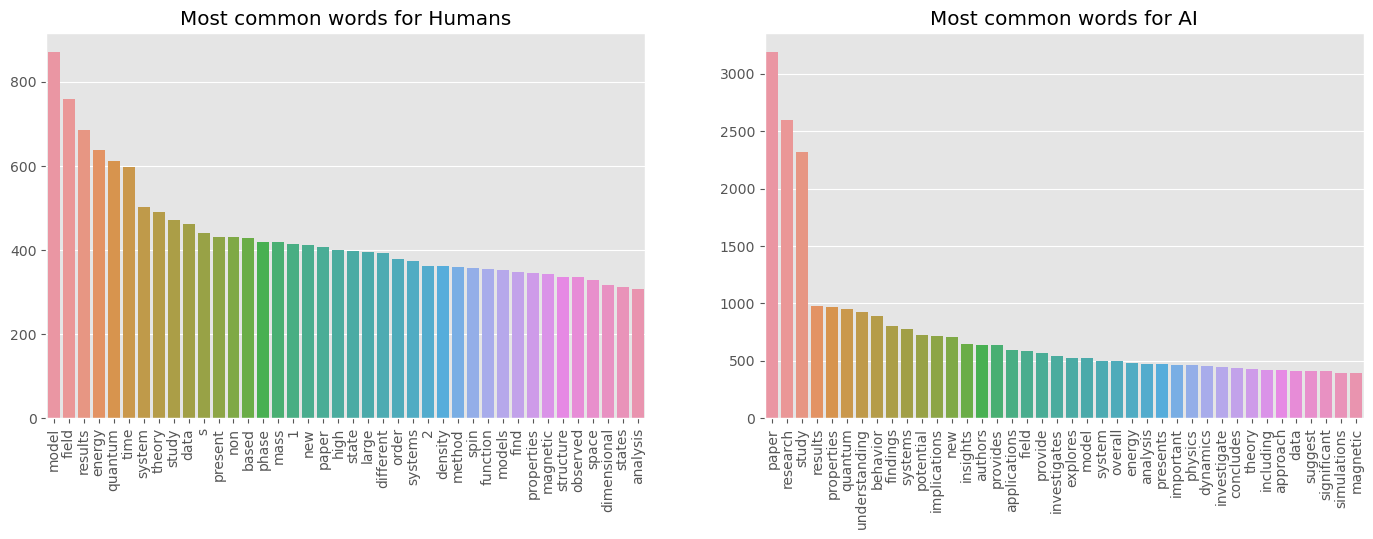

In [14]:
fig, axes = plt.subplots(1,2, figsize = (17,5))
sns.barplot(x = list(most_1_human.keys()), y = list(most_1_human.values()), ax = axes[0]).set(title="Most common words for Humans")
sns.barplot(x = list(most_1_ai.keys()), y = list(most_1_ai.values()), ax = axes[1]).set(title="Most common words for AI")
axes[0].tick_params(axis='x', rotation = 90)
axes[1].tick_params(axis='x', rotation = 90)
plt.show()

#### Bigrams

/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

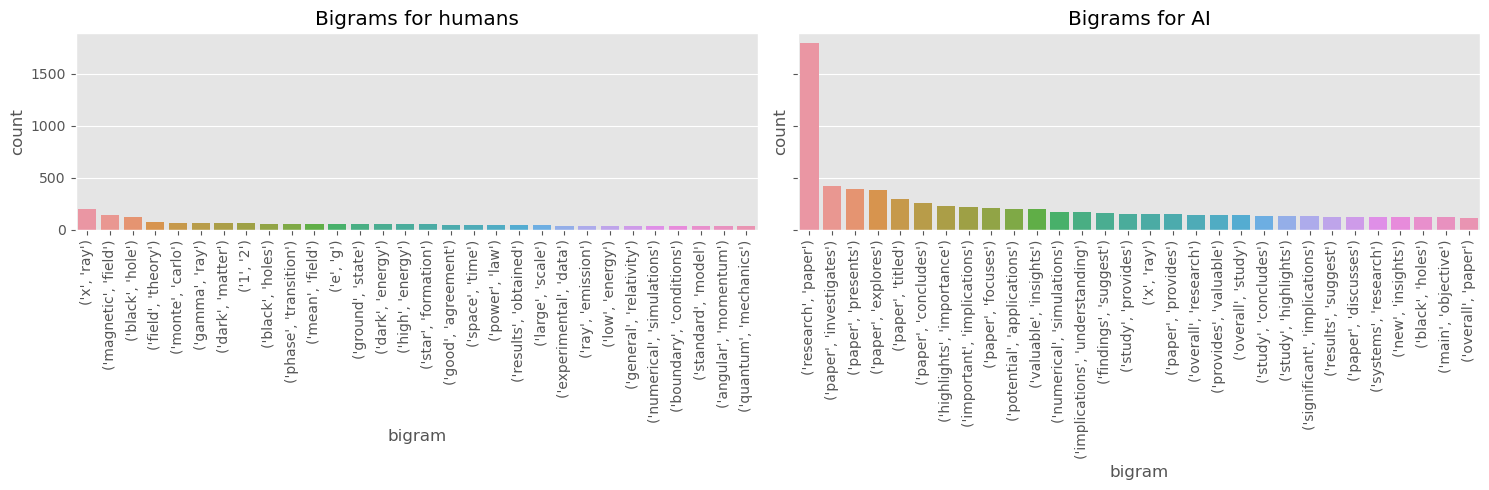

In [15]:
humans = data[data['is_ai_generated']==0]
corpus_humans = [word for i in humans.abstract_clean.str.split().values.tolist() for word in i]
bigrams_humans = (pd.Series(nltk.ngrams(corpus_humans, 2)).value_counts())
bigrams_df_h = bigrams_humans.reset_index()
bigrams_df_h.columns = ['bigram', 'count']

AI = data[data['is_ai_generated']==1]
corpus_AI = [word for i in AI.abstract_clean.str.split().values.tolist() for word in i]
bigrams_AI = (pd.Series(nltk.ngrams(corpus_AI, 2)).value_counts())
bigrams_df_AI = bigrams_AI.reset_index()
bigrams_df_AI.columns = ['bigram', 'count']

fig, axes = plt.subplots(1,2, figsize = (15,5), sharey=True)
sns.barplot(bigrams_df_h.head(30), x = 'bigram', y ='count', ax=axes[0]).set(title = 'Bigrams for humans')
sns.barplot(bigrams_df_AI.head(30), x = 'bigram', y ='count', ax=axes[1]).set(title = 'Bigrams for AI')
axes[0].tick_params(axis='x', rotation = 90)
axes[1].tick_params(axis='x', rotation = 90)
plt.tight_layout()

#### Trigrams

/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

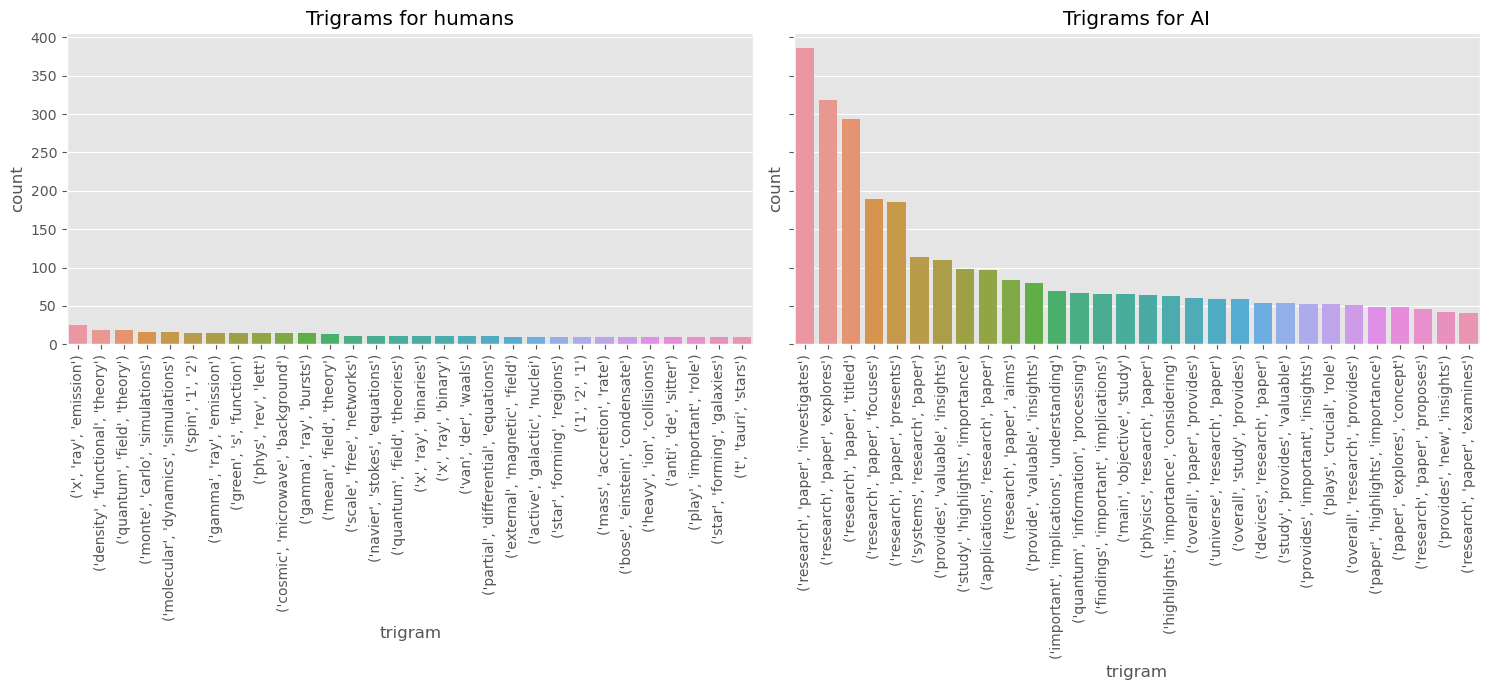

In [16]:
trigrams_humans = (pd.Series(nltk.ngrams(corpus_humans, 3)).value_counts())
trigrams_df_h = trigrams_humans.reset_index()
trigrams_df_h.columns = ['trigram', 'count']

trigrams_AI = (pd.Series(nltk.ngrams(corpus_AI, 3)).value_counts())
trigrams_df_AI = trigrams_AI.reset_index()
trigrams_df_AI.columns = ['trigram', 'count']

fig, axes = plt.subplots(1,2, figsize = (15,7), sharey= True) 
sns.barplot(trigrams_df_h.head(30), x = 'trigram', y ='count', ax=axes[0]).set(title = 'Trigrams for humans')
sns.barplot(trigrams_df_AI.head(30), x = 'trigram', y ='count', ax=axes[1]).set(title = 'Trigrams for AI')
axes[0].tick_params(axis='x', rotation = 90)
axes[1].tick_params(axis='x', rotation = 90)
plt.tight_layout()

# New column

In [17]:
corpus = [word for i in data.abstract_clean.str.split().values.tolist() for word in i]
bigram = (pd.Series(nltk.ngrams(corpus, 2)).value_counts())
unique_bigrams = bigram.head(50).index.tolist()
data['total_bigram_count'] = 0

In [18]:
def sum_bigram_counts(row):
    words = row['abstract_clean'].split()
    row_bigrams = list(nltk.ngrams(words, 2))
    
    # if the bigram is one of the 50 most frequent and if it is in the row sum 1
    row_count = sum(1 for bigram in row_bigrams if bigram in unique_bigrams)
    
    row['total_bigram_count'] = row_count

    return row

In [19]:
data = data.apply(sum_bigram_counts, axis=1)
data

,title,abstract,ai_generated,is_ai_generated,length,words,sentences,abstract_clean,total_bigram_count
0,Are Advanced Potentials Anomalous?,Advanced electromagnetic potentials are indi...,False,0,1157,164,7,advanced electromagnetic potentials indigenous...,0
1,Are Advanced Potentials Anomalous?,This research paper investigates the question ...,True,1,642,93,5,research paper investigates question advanced ...,5
2,An efficient centralized binary multicast netw...,We give an algorithm for finding network enc...,False,0,507,77,4,algorithm finding network encoding decoding eq...,0
3,An efficient centralized binary multicast netw...,The paper presents an efficient centralized bi...,True,1,940,125,6,paper presents efficient centralized binary mu...,2
4,Percolation transition in networks with degree...,We introduce an exponential random graph mod...,False,0,966,139,6,introduce exponential random graph model netwo...,1
...,...,...,...,...,...,...,...,...,...
4048,Vortex Dynamics at the Initial Stage of Resist...,This research paper investigates the vortex dy...,True,1,597,90,4,research paper investigates vortex dynamics su...,3
4049,The Veldkamp Space of Two-Qubits,Given a remarkable representation of the gen...,False,0,590,91,2,given remarkable representation generalized pa...,0
4050,The Veldkamp Space of Two-Qubits,The Veldkamp space of two-qubits is a mathemat...,True,1,901,130,6,veldkamp space qubits mathematical object desc...,4
4051,Fusion process studied with preequilibrium gia...,The equilibration of macroscopic degrees of ...,False,0,1069,163,8,equilibration macroscopic degrees freedom fusi...,1


____________

# Features Extraction

List of features to extract: 
1. Features that identify diversity and richness in the vocabulary (if we have to choose, keep Herdan's C, it's the best one for the task according to a paper)
    - Herdan's C
    - MaaS
    - Simpson's index

2. Perplexity distribution
3. Grammar Score 
4. N-grams distribution -> in the end no: it's shit to be summarized (the means are all low and don't make distinctions between Human and AI)
5. Type Token Ratio (TTR) on N-grams for N=1,2,3
6. Length (article - level: done in the eda, column 'words')
7. Average token length


Everything done on partially pre-procesed articles: only no punctuation but we keep the stopwords.

Before getting the features, we add some columns to the dataset that containg infromations needed to compute more then one feature. We will drop these columns afterwards. 

In [35]:
# article_clean as a list, useful
data['abstract_list'] = data.abstract_nopunct.apply(str.split)

# Number of words in each article 
data['words_number'] = data.abstract_list.apply(len)


Computing the vocabulary

In [120]:
vocabulary = Counter(reduce(lambda x,y : x+y, data.abstract_list.values))

# get the vocabulary length and its log (for Herdan's C and MaaS)
voc_len = len(vocabulary)
log_voc_len = np.log(voc_len)


In [131]:
# Herdan's C
data['herdan'] = data.words.apply(lambda row: log_voc_len/np.log(row))

# MaaS
data['maas'] = data.words.apply(lambda row: (log_voc_len - np.log(row)) / np.log((voc_len**2)) )

# Simpson's index 
data['tf'] = data.abstract_list.apply(lambda row: Counter(row))
data['tf'] = data.tf.apply(lambda row: row.values())
simpson_help = zip(data.tf, list(data.words))
data['simpson'] = list(simpson_help)
data['simpson'] = data.simpson.apply(lambda row: [(val/row[1])**2 for val in row[0]]).apply(lambda row: 1-sum(row))

# Grammar score 
tool = language_tool_python.LanguageTool('en-US')
data['grammar_score'] = data.abstract.apply(lambda row: len(tool.check(row))) #number of errors per row
grammar_score_help = zip(data.grammar_score, data.words)
data['grammar_score'] = list(grammar_score_help)
data['grammar_score'] = data.grammar_score.apply(lambda row: (row[0]/row[1]) ) #compute grammar score

# TTR on the whole text = on 1-grams (saved as TTR1)
# for this section: type = len(tf), token = words
data['TTR1'] = list(zip(list(data.tf.apply(len)), data.words))  #assign (type, token) as value for each row
data['TTR1'] = data.TTR1.apply(lambda row: row[0]/row[1])       #compute TTR

# TTR on 2-grams, prevalence of 2grams
data['bigrams'] = data.abstract_clean.apply(str.split).apply(lambda row: nltk.ngrams(row, 2)) #create bigrams for each document
data['prevalence2'] = data.bigrams.apply(Counter                                     #count the occurency of each bigram
                                  ).apply(lambda row: (len(row), sum(row.values()) ) #returns (type, token) couple for each row
                                  ).apply(lambda row: row[0]/row[1] )                #computes TTR

data.drop('bigrams', axis=1, inplace=True)

#TTR on 3-grams, prevalence of trigrams
data['trigrams'] = data.abstract_clean.apply(str.split).apply(lambda row: nltk.ngrams(row, 3)) #create bigrams for each document
data['prevalence3'] = data.trigrams.apply(Counter                                    #count the occurencies of each trigram
                                  ).apply(lambda row: (len(row), sum(row.values()) ) #returns (type, token) couple for each row
                                  ).apply(lambda row: row[0]/row[1] )                #computes TTR

data.drop('trigrams', axis=1, inplace=True)

# Average token length 
data['avg_token_length'] = data.abstract_list.apply(lambda row: [len(word) for word in row]).apply(lambda row: sum(row)/len(row))

In [195]:
data

,title,abstract,ai_generated,is_ai_generated,length,words,sentences,abstract_clean,total_bigram_count,abstract_list,herdan,abstract_nopunct,maas,tf,simpson,grammar_score,TTR1,TTR2,TTR3,avg_token_length
0,Are Advanced Potentials Anomalous?,Advanced electromagnetic potentials are indi...,False,0,1157,164,7,advanced electromagnetic potentials indigenous...,0,"[advanced, electromagnetic, potentials, are, i...",1.907805,advanced electromagnetic potentials are indige...,0.237919,"(3, 1, 2, 5, 1, 3, 13, 1, 1, 3, 1, 1, 1, 1, 1,...",0.981187,0.006098,0.646341,0.977011,1.000000,5.617647
1,Are Advanced Potentials Anomalous?,This research paper investigates the question ...,True,1,642,93,5,research paper investigates question advanced ...,5,"[this, research, paper, investigates, the, que...",2.146572,this research paper investigates the question ...,0.267070,"(1, 2, 3, 1, 7, 1, 4, 1, 5, 5, 3, 2, 1, 1, 1, ...",0.974217,0.010753,0.688172,0.895833,0.978723,5.849462
2,An efficient centralized binary multicast netw...,We give an algorithm for finding network enc...,False,0,507,77,4,algorithm finding network encoding decoding eq...,0,"[we, give, an, algorithm, for, finding, networ...",2.239868,we give an algorithm for finding network encod...,0.276773,"(1, 1, 1, 2, 2, 1, 2, 3, 4, 1, 1, 1, 1, 1, 1, ...",0.972677,0.012987,0.740260,1.000000,1.000000,5.217949
3,An efficient centralized binary multicast netw...,The paper presents an efficient centralized bi...,True,1,940,125,6,paper presents efficient centralized binary mu...,2,"[the, paper, presents, an, efficient, centrali...",2.015103,the paper presents an efficient centralized bi...,0.251874,"(11, 2, 1, 1, 1, 2, 1, 3, 8, 2, 6, 3, 1, 3, 3,...",0.974208,0.000000,0.608000,0.950000,1.000000,6.456000
4,Percolation transition in networks with degree...,We introduce an exponential random graph mod...,False,0,966,139,6,introduce exponential random graph model netwo...,1,"[we, introduce, an, exponential, random, graph...",1.971750,we introduce an exponential random graph model...,0.246418,"(2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 6, 3, 3, ...",0.966979,0.021583,0.575540,0.924051,0.987179,5.562500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4048,Vortex Dynamics at the Initial Stage of Resist...,This research paper investigates the vortex dy...,True,1,597,90,4,research paper investigates vortex dynamics su...,3,"[this, research, paper, investigates, the, vor...",2.162214,this research paper investigates the vortex dy...,0.268756,"(1, 1, 1, 1, 16, 3, 2, 1, 2, 1, 2, 4, 2, 2, 2,...",0.949630,0.000000,0.566667,0.851064,0.956522,5.600000
4049,The Veldkamp Space of Two-Qubits,Given a remarkable representation of the gen...,False,0,590,91,2,given remarkable representation generalized pa...,0,"[given, a, remarkable, representation, of, the...",2.156917,given a remarkable representation of the gener...,0.268188,"(1, 1, 1, 1, 11, 10, 2, 2, 3, 3, 1, 2, 1, 2, 1...",0.958097,0.098901,0.637363,0.940000,1.000000,4.835052
4050,The Veldkamp Space of Two-Qubits,The Veldkamp space of two-qubits is a mathemat...,True,1,901,130,6,veldkamp space qubits mathematical object desc...,4,"[the, veldkamp, space, of, two, qubits, is, a,...",1.998866,the veldkamp space of two qubits is a mathemat...,0.249858,"(14, 4, 5, 10, 3, 2, 1, 3, 2, 1, 1, 1, 1, 1, 1...",0.965976,0.053846,0.561538,0.929577,0.985714,5.706767
4051,Fusion process studied with preequilibrium gia...,The equilibration of macroscopic degrees of ...,False,0,1069,163,8,equilibration macroscopic degrees freedom fusi...,1,"[the, equilibration, of, macroscopic, degrees,...",1.910096,the equilibration of macroscopic degrees of fr...,0.238233,"(18, 1, 7, 1, 1, 1, 1, 5, 2, 1, 2, 1, 3, 1, 2,...",0.974406,0.049080,0.656442,0.946237,0.989130,5.029070
